# Data Preprocessing





Importing Necessary Libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

Load and preprocess data

In [8]:
data = pd.read_csv("demand_inventory.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Date,Product_ID,Demand,Inventory
0,2023-06-01,P1,51,5500
1,2023-06-02,P1,141,5449
2,2023-06-03,P1,172,5308
3,2023-06-04,P1,91,5136
4,2023-06-05,P1,198,5045


Feature engineering: Add date-related features

In [9]:
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

Encode categorical variables

In [10]:
data['Product_ID_Encoded'] = LabelEncoder().fit_transform(data['Product_ID'])


Add lag and rolling features

In [11]:
data['Lag_1'] = data['Demand'].shift(1)
data['Rolling_Mean_7'] = data['Demand'].rolling(window=7).mean()

Drop NaN rows

In [12]:
data = data.dropna()

Define features and target

In [13]:
features = ['Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Product_ID_Encoded', 'Inventory', 'Lag_1', 'Rolling_Mean_7']
target = 'Demand'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train Models and Compare Scores

Importing Libraries

In [14]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Initialize models

In [15]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, force_row_wise=True)}

Train models and evaluate

In [16]:
scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    scores[name] = {'R²': r2, 'MAE': mae, 'RMSE': rmse}
    print(f"{name} - R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Random Forest - R²: -0.1693, MAE: 46.4908, RMSE: 52.0783
XGBoost - R²: -0.6311, MAE: 52.4372, RMSE: 61.5104
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 5
[LightGBM] [Info] Start training from score 120.204545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

# Select Best Model

In [17]:
best_model_name = max(scores, key=lambda name: scores[name]['R²'])
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")


Best Model: LightGBM


# Predict Future Demand with Best Model

In [18]:
future_steps = 10
last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

future_data = pd.DataFrame({
    'Date': future_dates,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'DayOfWeek': future_dates.dayofweek,
    'WeekOfYear': future_dates.isocalendar().week,
    'Product_ID_Encoded': [0] * future_steps,  # Example for one product
    'Inventory': [data['Inventory'].iloc[-1]] * future_steps,
    'Lag_1': [data['Demand'].iloc[-1]] * future_steps,
    'Rolling_Mean_7': [data['Demand'].iloc[-7:].mean()] * future_steps
})


Predict with the best model

In [19]:
future_predictions = best_model.predict(future_data[features])
future_data['Predicted_Demand'] = future_predictions

Display future predictions

In [20]:
print("\nFuture Predictions:")
print(future_data[['Date', 'Predicted_Demand']])


Future Predictions:
                 Date  Predicted_Demand
2023-08-02 2023-08-02         108.67844
2023-08-03 2023-08-03         108.67844
2023-08-04 2023-08-04         108.67844
2023-08-05 2023-08-05         108.67844
2023-08-06 2023-08-06         108.67844
2023-08-07 2023-08-07         108.67844
2023-08-08 2023-08-08         108.67844
2023-08-09 2023-08-09         108.67844
2023-08-10 2023-08-10         108.67844
2023-08-11 2023-08-11         108.67844


# Interpreting The Model Performance

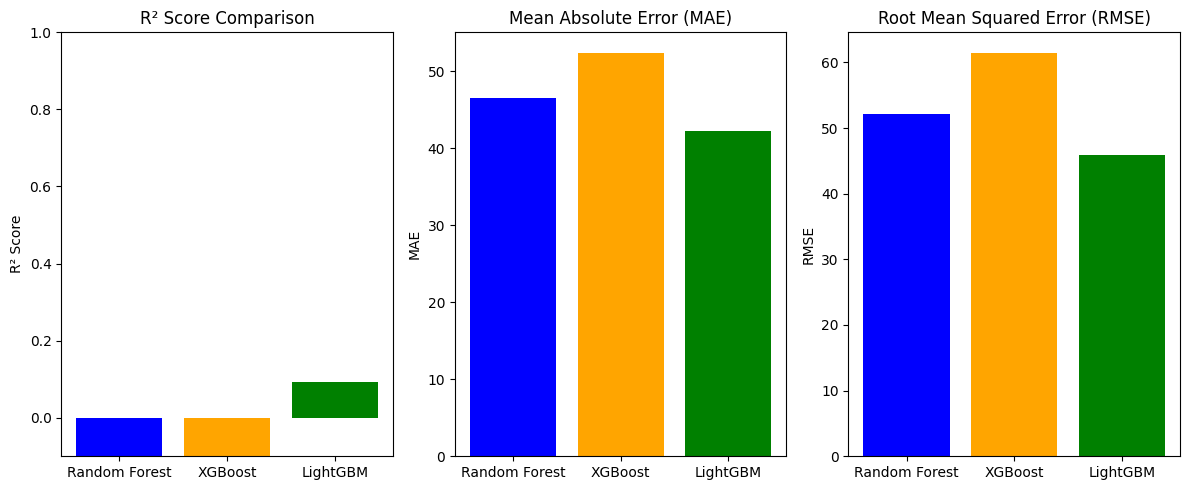

In [39]:
import matplotlib.pyplot as plt

# Extract scores for visualization
model_names = list(scores.keys())
r2_scores = [scores[name]['R²'] for name in model_names]
mae_scores = [scores[name]['MAE'] for name in model_names]
rmse_scores = [scores[name]['RMSE'] for name in model_names]

# Plot R² scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.bar(model_names, r2_scores, color=['blue', 'orange', 'green'])
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(-0.1, 1.0)

# Plot MAE scores
plt.subplot(1, 3, 2)
plt.bar(model_names, mae_scores, color=['blue', 'orange', 'green'])
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("MAE")

# Plot RMSE scores
plt.subplot(1, 3, 3)
plt.bar(model_names, rmse_scores, color=['blue', 'orange', 'green'])
plt.title("Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()


# Visualizing Future Predictions

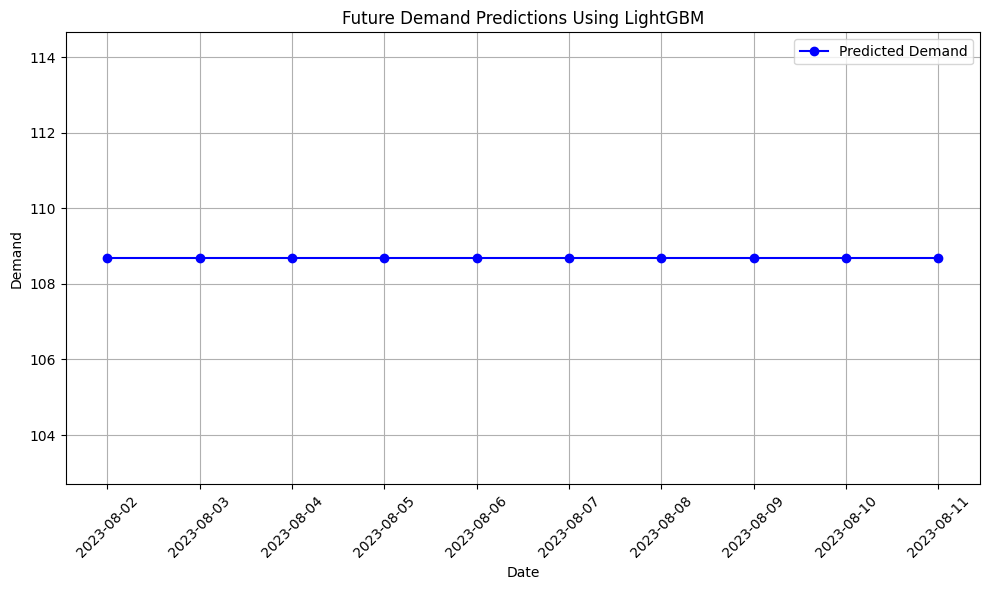

In [40]:
# Plot future demand predictions
plt.figure(figsize=(10, 6))
plt.plot(future_data['Date'], future_data['Predicted_Demand'], marker='o', color='blue', label="Predicted Demand")
plt.title(f"Future Demand Predictions Using {best_model_name}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
